## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [27]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [28]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    textEo = iofile.readlines()

textEo = [x.replace('\t\t', '') for x in text]

--2024-05-07 12:58:00--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2024-05-07 12:58:01 (2.33 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.
out = ''.join(textEo).lower()


# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
# Your great code here
# Create a sorted list of unique characters
# Dictionary mapping index to character
idx_to_token = {index: char for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
# Dictionary mapping character to index
token_to_idx = {char: index for index, char in enumerate(tokens)}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
# Your code here

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

# Assuming text is already loaded and preprocessed as in your snippet

# Constants
MAXLEN = 40  # Length of extracted character sequences
STEP = 3  # Step size for moving the reading window

# Prepare the text
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Cut the text in semi-redundant sequences of MAXLEN characters
sentences = []
next_chars = []
for i in range(0, len(text) - MAXLEN, STEP):
    sentences.append(text[i: i + MAXLEN])
    next_chars.append(text[i + MAXLEN])

# One-hot encoding
x = np.zeros((len(sentences), MAXLEN, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = True
    y[i, char_indices[next_chars[i]]] = True

# Build the model: a single LSTM
model = Sequential([
    SimpleRNN(128, input_shape=(MAXLEN, len(chars))),
    Dense(len(chars), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

# Helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Function invoked at end of each epoch to print generated text
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(text) - MAXLEN - 1)
    generated = ''
    sentence = text[start_index: start_index + MAXLEN]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, MAXLEN, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = True

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature=1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


Plot the loss function (axis X: number of epochs, axis Y: loss function).

Epoch 1/60
261/261 [==============================] - ETA: 0s - loss: 2.3083
----- Generating text after Epoch: 0
----- Generating with seed: "ywhere!
  and yet this time removed was "
ywhere!
  and yet this time removed was seumh trekmog,le ke otheppeesoy in theppbuthrag momend lpeike ancert
  an pfyut tey alouthy mire iv
  tty wollw face ii h lt yhiartm too  yoerting  ant are unov soog thou coy thenhy yihishare lose nha shee gfrotofe aiverldns ngt theth n, re this
  inre s ofswetot, mserblara!d fwavt, hath sie,
  rothbefllref mavl soate, ney thy bfmasd boven thyolongth snortheute tlames hue my hee thyer sove
  fsirg
261/261 [==============================] - 84s 322ms/step - loss: 2.3083
Epoch 2/60
260/261 [============================>.] - ETA: 0s - loss: 2.1660
----- Generating text after Epoch: 1
----- Generating with seed: "t wherefore do not you a mightier way
  "
t wherefore do not you a mightier way
  hous thar whme an ine to hot at thy wrer thou;
  o thou moue suthhe e eor wa

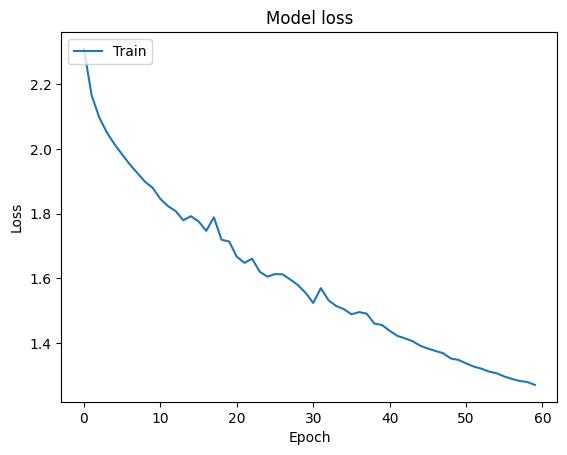

In [32]:
import sys
# Your plot code here
history = model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=[print_callback])

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


In [33]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0, token_to_idx=None, idx_to_token=None):
    '''
    Generates text given a phrase of length at least SEQ_LENGTH.

    :param char_rnn: The trained character RNN model.
    :param seed_phrase: The initial string to start text generation.
    :param max_length: The maximum length of the generated text.
    :param temperature: The temperature for sampling (controls randomness).
    :param token_to_idx: Dictionary mapping characters to their indices.
    :param idx_to_token: Dictionary mapping indices back to characters.
    '''
    # Initialize the sequence of indices with the seed phrase
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Initial hidden state
    hid_state = char_rnn.initial_state(batch_size=1)

    # Feed the seed phrase to the RNN to build up the hidden state
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, i:i+1], hid_state)

    # Generate new characters
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1:], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0, -1]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix_tensor = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix_tensor], dim=1)

    # Convert indices to characters
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

# Example usage (assuming you have a trained model 'char_rnn', and dictionaries 'token_to_idx', 'idx_to_token'):
# print(generate_sample(char_rnn, seed_phrase=" Hello", max_length=100, temperature=0.5, token_to_idx=token_to_idx, idx_to_token=idx_to_token))


In [44]:
def generate_text(model, char_to_index, indices_char, seed_phrase="Hello", length=500, temperature=0.2):
    """
    Generate text using a trained RNN model.

    :param model: Trained Keras model
    :param char_to_index: Dictionary mapping characters to their indices
    :param indices_char: Dictionary mapping indices to their characters
    :param seed_phrase: Initial phrase to start text generation
    :param length: Total length of the text to generate
    :param temperature: Sampling temperature
    """
    seed_phrase = seed_phrase.lower()
    seed_length = len(seed_phrase)
    if seed_length < MAXLEN:
        # Pad the seed_phrase if it's too short
        seed_phrase = seed_phrase.rjust(MAXLEN)
    elif seed_length > MAXLEN:
        # Truncate the seed_phrase if it's too long
        seed_phrase = seed_phrase[:MAXLEN]
    # Prepare the seed phrase as the initial input to the model
    generated = seed_phrase.lower()
    sentence = seed_phrase.lower()

    # Generate the text
    for i in range(length - len(seed_phrase)):
        # Prepare the input tensor
        x_pred = np.zeros((1, len(sentence), len(char_to_index)), dtype=np.bool_)
        for t, char in enumerate(sentence):
            x_pred[0, t, char_to_index[char]] = True

        # Make a prediction (output is logits, not probabilities)
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        # Append the new character and shift the sentence to include it
        generated += next_char
        sentence = sentence[1:] + next_char

        # Reset the sentence if it gets too long to process (optional)
        if len(sentence) > MAXLEN:
            sentence = sentence[-MAXLEN:]

    return generated

def sample(preds, temperature=1.0):
    """ Helper function to sample an index from a probability array """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature  # avoid log(0) error
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [45]:
# Example usage:
# Assume `model`, `char_to_index`, and `indices_char` are already defined
generated_text = generate_text(model, char_indices, indices_char, seed_phrase="Hello dier frend", length=500, temperature=0.2)
print(generated_text)

                        hello dier frend by all my my save mone owner shom made:
  thene all then me,
  the pays be do thy haugh thee thou all hel, thy self which in thee,
    then with me pressuch with me mines worls make the with my love storns medsell his such it thy splise,
  and thee my sear with thy heart theerthen trough they thee thee, me when the with thee, nor pach!
    and stear then,--hoult the such i shile,
    and thee thee,
  then thou sull thines worle waike h trous well and they


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [47]:
from tensorflow.keras.layers import LSTM
# Your beautiful code here
# Build the model: a single LSTM
modelLSTM = Sequential([
    LSTM(128, input_shape=(MAXLEN, len(chars))),
    Dense(len(chars), activation='softmax'),
])

modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

Epoch 1/60
261/261 [==============================] - ETA: 0s - loss: 2.8856
----- Generating text after Epoch: 0
----- Generating with seed: "this,
    give them thy fingers, me thy "
this,
    give them thy fingers, me thy crult:
    the sin
  hour erot,
  and and that love it is to my whine i parthes wece, so acpin
  lowh for wors, and the weras the fread th yet that they thou kenow make bearty seme the weld mesere which is my maken; being these of my sugh days;
  wheremed to saby
  of thust so beauty that is theart, whene pirst non expur-fos bulf, a saby mores bester't andpo't dase pave.
  prist then then thinks t
261/261 [==============================] - 118s 444ms/step - loss: 2.8856
Epoch 2/60
261/261 [==============================] - ETA: 0s - loss: 2.4474
----- Generating text after Epoch: 1
----- Generating with seed: "away, art present still with me;
  for t"
away, art present still with me;
  for try may:
   hat till's foam,
  for oum-sues, a toubl.

  xiving,
  aud wo th

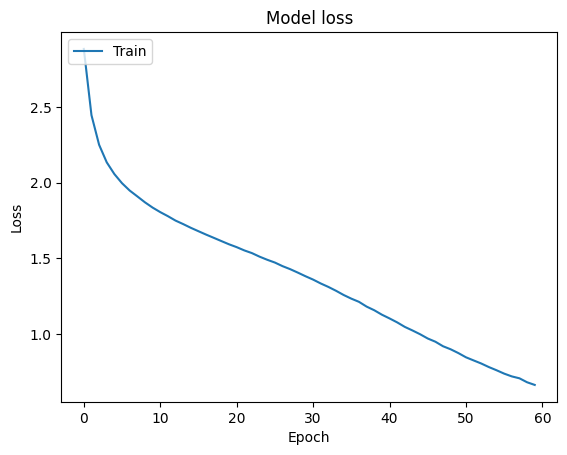

In [48]:
history = modelLSTM.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=[print_callback])

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [49]:
# Text generation with different temperature values here
phrase = 'Which on thy soft cheek for complexion dwells'
for temp in [0.1, 0.2, 0.5, 1.0, 1.2]:
  print(f"Temperature: {temp}")
  print('vanilla RNN: ',generate_text(model, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))
  print('LSTM: ', generate_text(modelLSTM, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))


Temperature: 0.1
vanilla RNN:  which on thy soft cheek for complexion de preasud;
  the live so belle trous, for a dot my liver star dift, not thee,
    then waile s origlle thien shempless as farter samper woth in then soult be whene the spelis the with thee, where the courin thy singlo thin steat thee for the then, thath the prin, the with thy heart her for my love that with heaver bear single the with thy heart and thee the with thise thy love and thee, where the cansus and thee thou make the with thee, a dote is geated th
LSTM:  which on thy soft cheek for complexion dweal,
  thy good all the warty thou live' wherespong
  for then that i have and canour out faire
    that love it of all thee fool her in had,
    far then i with times he subjed wher sart,
  sorss all torree the warls where hall nor day;
    thes flower, were thy love that despetes'd doad st;
  brown that dearter's stringth, or deat no gre,
  ande the pear the beauty should the senout,
  some their artand of torbe th

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [50]:
# Saving and loading code here

In [51]:
model.save('Shakespeare_sonnets_vanilla_RNN.h5')
modelLSTM.save('Shakespeare_sonnets_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
from tensorflow.keras.models import load_model

# Load models
loaded_vanilla_rnn = load_model('Shakespeare_sonnets_vanilla_RNN.h5')
loaded_lstm = load_model('Shakespeare_sonnets_LSTM.h5')

In [54]:
phrase1 = 'The sun shine'
print('vanilla RNN: ',generate_text(loaded_vanilla_rnn, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))
print('LSTM: ', generate_text(loaded_lstm, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))


vanilla RNN:                             the sun shine of thee.
    then with this swelt muth leved be;
  then thou art me conquiend chould by sering,
  when the with theer no thine ownen y then sour'd swey?
  which the with the wear shale mine eyes thee, a dote can leed no dencamperid
    and thee thou art of thee.
  the rang thee.
  when thee, shall will false thence fall then thou marn the eath thy hould but fair thee thee thou sind thy senst the cheres in the with thee, who grons deding thy spees to thee,
LSTM:                             the sun shineed doth are manow rep to de,
  the ever love own well chill bo thy lie,
  which till, lowe will nourselly out dear,
  then most hast infulterent trou thees,
  with ib thy good all this fror marnter's,
  which i thee for mand cands and more thy swoond,
  and that life is my liffe thine eyes de
  hate of all thee berovons of the face then show
  to thee to dombothess wo love to dide tree,
    then love, when streaving of that i solf.

 

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)